# Import necessary libraries

In [77]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer

# NN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, SimpleRNN,LSTM,GRU,Bidirectional

# text augmentation
import nlpaug.augmenter.word as naw

# Read data

In [3]:
data = pd.read_csv('train.csv')

In [4]:
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
# select required columns
df = data[['label','tweet']]

In [6]:
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 499.5+ KB


In [8]:
df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

# Text pre-processing

In [9]:
# create function to lower the text, remove white space,# and @user, remove apostrophe words, tokenization and lemmatization

def clean_text(doc):
    
    # lower the text
    doc = doc.lower()
    
    # remove white space,# and @user 
    doc = re.sub('@user|#','',doc)
    doc = re.sub(' +',' ',doc)
    doc = re.sub('^\s+|\s$','',doc)
    
    # remove apostrophe words
    doc = doc.split()
    doc = [t for t in doc if not re.search("\'",t)]
    # check for alpha
    doc = [t for t in doc if t.isalpha()]
    doc = ' '.join(doc)
    return doc
    
    # tokenization
    tokens = word_tokenize(doc)
    stop = stopwords.words('english')   # stop words
    punct = list(punctuation)           # punctuations
    bad_tokens = stop + punct
    clean_tokens = [t for t in tokens if t not in bad_tokens]
    
    # lemmatization
    lemma = WordNetLemmatizer()
    clean_tokens = [lemma.lemmatize(t) for t in clean_tokens]
    
    return ' '.join(clean_tokens)


In [10]:
# apply clean text function
df['cleantxt'] = df.tweet.apply(clean_text)

In [11]:
df

,label,tweet,cleantxt
0,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i use cause they offer ...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,model i love u take with u all the time in
4,0,factsguide: society now #motivation,society now motivation
...,...,...,...
31957,0,ate @user isz that youuu?ðððððð...,ate isz that
31958,0,to see nina turner on the airwaves trying to...,to see nina turner on the airwaves trying to w...
31959,0,listening to sad songs on a monday morning otw...,listening to sad songs on a monday morning otw...
31960,1,"@user #sikh #temple vandalised in in #calgary,...",sikh temple vandalised in in wso condemns act


# Visualization

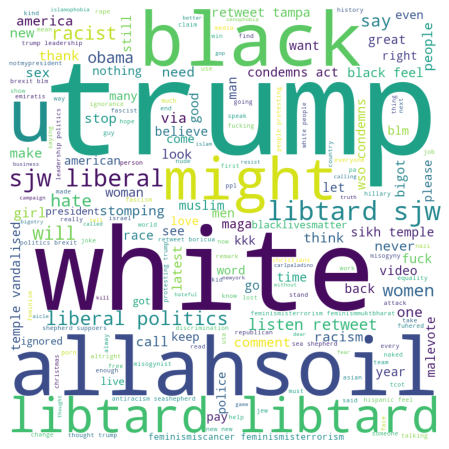

In [80]:
# racist wordcloud

wc = WordCloud(width=800, 
               height=800, 
               background_color="white",
               min_font_size=10)

racistgraph = " ".join(df[df["label"] == 1]["cleantxt"])

wc.generate(racistgraph)

plt.figure(figsize=(8,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

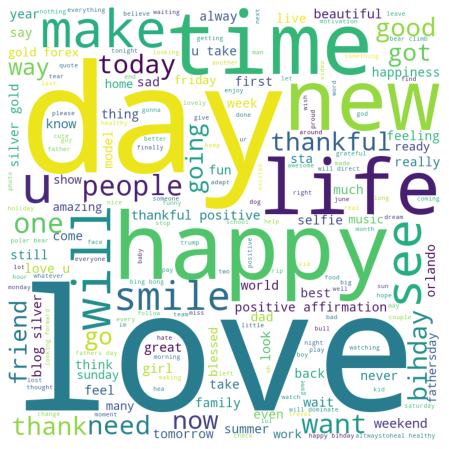

In [81]:
# not racist wordcloud

wc = WordCloud(width=800, 
               height=800, 
               background_color="white",
               min_font_size=10)

notracistgraph = " ".join(df[df["label"] == 0]["cleantxt"])

wc.generate(notracistgraph)

plt.figure(figsize=(8,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

<AxesSubplot:>

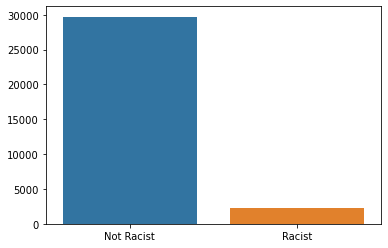

In [90]:
sns.barplot(y=df.label.value_counts().values,x=['Not Racist','Racist'])

# Model Building

In [12]:
# seperate feature and target
X = df["cleantxt"]
y = df["label"]

In [14]:
# split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1,stratify=y)

In [15]:
len(X_train),len(X_test),len(y_train),len(y_test)

(25569, 6393, 25569, 6393)

In [16]:
# Returning to one dataframe
training_set = pd.concat([X_train, y_train], axis=1)

In [17]:
len(training_set)

25569

In [18]:
# seperate classes
racist = training_set[training_set.label==1]
notracist = training_set[training_set.label==0]

In [19]:
# length of minority class
len(racist)

1794

In [20]:
# length of majority class
len(notracist)

23775

In [21]:
# function to store upsampled data into list

tr = []
def upsample(doc):
    aug = naw.SynonymAug(aug_src='wordnet')
    tr.append(doc)
    for i in range(14):
        augmented_text = aug.augment(doc)
        tr.append(augmented_text)


In [22]:
# apply function

racist['cleantxt'].apply(upsample)

16512    None
2993     None
5843     None
31483    None
1779     None
         ... 
405      None
21877    None
23375    None
27026    None
25917    None
Name: cleantxt, Length: 1794, dtype: object

In [25]:
# create dataframe of upsampled list
upsample_racist = pd.DataFrame(tr,columns=['cleantxt'])

In [27]:
# drop duplicates
upsample_racist = upsample_racist.drop_duplicates()

In [28]:
upsample_racist['label'] = 1

In [29]:
upsample_racist

,cleantxt,label
0,holiday socially podcast celebrates bewitched ...,1
1,holiday socially podcast celebrates bewitched ...,1
2,vacation socially podcast celebrates bewitched...,1
5,holiday socially podcast celebrates bewitched ...,1
6,holiday socially podcast celebrates fascinate ...,1
...,...,...
26890,final retro christmasadve for you this and whi...,1
26891,last retro christmasadve for you this and whil...,1
26892,last retro christmasadve for you this and whil...,1
26893,last retro christmasadve for you this and whil...,1


In [30]:
# new upsampled training set
upsampled_train = pd.concat([upsample_racist,notracist])

In [31]:
upsampled_train.head()

,cleantxt,label
0,holiday socially podcast celebrates bewitched ...,1
1,holiday socially podcast celebrates bewitched ...,1
2,vacation socially podcast celebrates bewitched...,1
5,holiday socially podcast celebrates bewitched ...,1
6,holiday socially podcast celebrates fascinate ...,1


In [32]:
# minority and majority class are almost equal
upsampled_train.label.value_counts()

0    23775
1    19526
Name: label, dtype: int64

<AxesSubplot:>

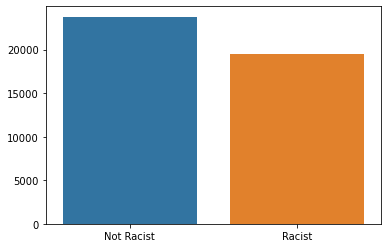

In [91]:
sns.barplot(y=upsampled_train.label.value_counts().values,x=['Not Racist','Racist'])

In [33]:
# Separate upsampled data into X and y sets
upsampled_x_train=upsampled_train.cleantxt
upsampled_y_train=upsampled_train.label

In [34]:
# tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(upsampled_x_train)

In [35]:
vocabulary = tokenizer.index_word

In [36]:
vocab_len = len(vocabulary)
vocab_len

31885

In [37]:
train_sequence = tokenizer.texts_to_sequences(upsampled_x_train)

In [38]:
doc_len = []
for doc in train_sequence:
    doc_len.append(len(doc))

In [39]:
max(doc_len)

30

In [40]:
np.quantile(doc_len, 0.98)

22.0

In [41]:
max_len = 22

In [42]:
# training
train_sequence_matrix = sequence.pad_sequences(train_sequence, maxlen= max_len,)

In [43]:
# testing
test_sequence = tokenizer.texts_to_sequences(X_test)
test_sequence_matrix = sequence.pad_sequences(test_sequence, maxlen= max_len)

In [44]:
model = Sequential()
model.add(Embedding(input_dim=vocab_len+1,output_dim=100,input_length=max_len,mask_zero=True))
model.add(Bidirectional(GRU(64,activation="relu")))
model.add(Dense(1000,activation="relu"))
model.add(Dense(980,activation="relu"))
model.add(Dense(808,activation="relu"))
model.add(Dense(578,activation="relu"))
model.add(Dense(400,activation="relu"))
model.add(Dense(280,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(1,activation='sigmoid'))

In [45]:
model.compile(optimizer="adam", loss="binary_crossentropy")
model.fit(train_sequence_matrix,upsampled_y_train, batch_size=28,epochs=50)

Epoch 1/50
1547/1547 [==============================] - 104s 65ms/step - loss: 0.1556
Epoch 2/50
1547/1547 [==============================] - 98s 63ms/step - loss: 0.0363
Epoch 3/50
1547/1547 [==============================] - 99s 64ms/step - loss: 0.0186
Epoch 4/50
1547/1547 [==============================] - 99s 64ms/step - loss: 0.0152
Epoch 5/50
1547/1547 [==============================] - 102s 66ms/step - loss: 0.0093
Epoch 6/50
1547/1547 [==============================] - 99s 64ms/step - loss: 0.0096
Epoch 7/50
1547/1547 [==============================] - 99s 64ms/step - loss: 0.0091
Epoch 8/50
1547/1547 [==============================] - 99s 64ms/step - loss: 0.0099
Epoch 9/50
1547/1547 [==============================] - 100s 65ms/step - loss: 0.0031
Epoch 10/50
1547/1547 [==============================] - 100s 64ms/step - loss: 0.0094
Epoch 11/50
1547/1547 [==============================] - 99s 64ms/step - loss: 0.0066
Epoch 12/50
1547/1547 [==============================] - 10

In [48]:
from sklearn.metrics import classification_report
y_pred = model.predict(test_sequence_matrix)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5945
           1       0.67      0.56      0.61       448

    accuracy                           0.95      6393
   macro avg       0.82      0.77      0.79      6393
weighted avg       0.95      0.95      0.95      6393



# Testing data

In [61]:
data = pd.read_csv('test.csv')

In [62]:
data.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [63]:
tdf = data[['tweet']]

In [64]:
tdf.head()

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone to s...
2,safe ways to heal your #acne!! #altwaystohe...
3,is the hp and the cursed child book up for res...
4,"3rd #bihday to my amazing, hilarious #nephew..."


In [66]:
# apply clean text function
tdf['cleantxt'] = tdf.tweet.apply(clean_text)

In [67]:
tdf.head()

,tweet,cleantxt
0,#studiolife #aislife #requires #passion #dedic...,studiolife aislife requires passion dedication...
1,@user #white #supremacists want everyone to s...,white supremacists want everyone to see the ne...
2,safe ways to heal your #acne!! #altwaystohe...,safe ways to heal your altwaystoheal healthy
3,is the hp and the cursed child book up for res...,is the hp and the cursed child book up for res...
4,"3rd #bihday to my amazing, hilarious #nephew...",bihday to my hilarious nephew eli uncle dave l...


In [68]:
tdf.cleantxt

0        studiolife aislife requires passion dedication...
1        white supremacists want everyone to see the ne...
2             safe ways to heal your altwaystoheal healthy
3        is the hp and the cursed child book up for res...
4        bihday to my hilarious nephew eli uncle dave l...
                               ...                        
17192         thought trump leadership politics brexit blm
17193    feeling like a mermaid hairflip neverready for...
17194    hillary campaigned today in used words like ne...
17195    at work right mindset leads to organizations w...
17196               my song free shoegaze newmusic newsong
Name: cleantxt, Length: 17197, dtype: object

In [69]:
X_test = tdf.cleantxt

In [70]:
# tokenization and text to sequennce and padding on testing data
test_sequence = tokenizer.texts_to_sequences(X_test)
test_sequence_matrix = sequence.pad_sequences(test_sequence, maxlen= max_len)

In [71]:
# Prediction of testing data
y_pred = model.predict(test_sequence_matrix)
y_pred = np.where(y_pred >= 0.5, 1, 0)

In [72]:
y_pred

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [74]:
tdf['label'] = y_pred

In [75]:
tdf.head()

,tweet,cleantxt,label
0,#studiolife #aislife #requires #passion #dedic...,studiolife aislife requires passion dedication...,0
1,@user #white #supremacists want everyone to s...,white supremacists want everyone to see the ne...,1
2,safe ways to heal your #acne!! #altwaystohe...,safe ways to heal your altwaystoheal healthy,0
3,is the hp and the cursed child book up for res...,is the hp and the cursed child book up for res...,0
4,"3rd #bihday to my amazing, hilarious #nephew...",bihday to my hilarious nephew eli uncle dave l...,0


In [76]:
# to csv
tdf.to_csv('predictions.csv')